# Introducing:

## Context:
The cleaned data set contains information of price, transmission, mileage, fuel type, road tax, miles per gallon (mpg), and engine size. I've removed duplicate listings and cleaned the columns, but have included a notebook showing the process and the original data for anyone who wants to check/improve my work.

## Task:
*Predict cars price*

## Used libraries:
- pandas
- numpy
- matplotlib
- optuna
- sklearn
- xgboost
- catboost

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,r2_score,mean_squared_error

import optuna
from optuna.visualization.matplotlib import plot_param_importances

# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval


from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Data preparation

In [2]:
df = pd.read_csv('/home/antonius/Projects/DS_Projects/Data-analysis-with-data-science/02_uk_used_cars_price_prediction/bmw.csv')
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


In [3]:
df.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

In [4]:
df.columns = ['model', 'year', 'price', 'transmission', 'mileage', 'fuel_type', 'tax',
       'mpg', 'engine_size']

In [5]:
df.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuel_type', 'tax',
       'mpg', 'engine_size'],
      dtype='object')

## Format data

In [6]:
len(df)

10781

### Skips, Nans

In [7]:
df.isna().mean().sort_values(ascending=False)

model           0.0
year            0.0
price           0.0
transmission    0.0
mileage         0.0
fuel_type       0.0
tax             0.0
mpg             0.0
engine_size     0.0
dtype: float64

In [8]:
df.dtypes

model            object
year              int64
price             int64
transmission     object
mileage           int64
fuel_type        object
tax               int64
mpg             float64
engine_size     float64
dtype: object

In [9]:
df.select_dtypes(include='object')

,model,transmission,fuel_type
0,5 Series,Automatic,Diesel
1,6 Series,Automatic,Petrol
2,5 Series,Automatic,Diesel
3,1 Series,Automatic,Diesel
4,7 Series,Automatic,Diesel
...,...,...,...
10776,X3,Automatic,Diesel
10777,5 Series,Automatic,Diesel
10778,3 Series,Manual,Petrol
10779,1 Series,Automatic,Diesel


## Feature Engineering

### Transform categories into numbers

In [10]:
df.select_dtypes(include='object').head()

,model,transmission,fuel_type
0,5 Series,Automatic,Diesel
1,6 Series,Automatic,Petrol
2,5 Series,Automatic,Diesel
3,1 Series,Automatic,Diesel
4,7 Series,Automatic,Diesel


#### transmission get_dummies

In [11]:
pd.get_dummies(df['transmission'],prefix='is').head()

,is_Automatic,is_Manual,is_Semi-Auto
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [12]:
df_dum_transmission =pd.get_dummies(df['transmission'],prefix='is')
df_dum_transmission.columns = map(str.lower, df_dum_transmission.columns)
df_dum_transmission.head()

,is_automatic,is_manual,is_semi-auto
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [13]:
df = pd.concat([df,df_dum_transmission],axis=1)
df.head()

,model,year,price,transmission,mileage,fuel_type,tax,mpg,engine_size,is_automatic,is_manual,is_semi-auto
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,1,0,0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,1,0,0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,1,0,0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,1,0,0
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,1,0,0


#### fuel_type get_dummies

In [14]:
df_dum_fuel_type =pd.get_dummies(df['fuel_type'],prefix='is')
df_dum_fuel_type.columns = map(str.lower, df_dum_fuel_type.columns)
df_dum_fuel_type.head()

,is_diesel,is_electric,is_hybrid,is_other,is_petrol
0,1,0,0,0,0
1,0,0,0,0,1
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [15]:
df = pd.concat([df,df_dum_fuel_type],axis=1)
df.head()

,model,year,price,transmission,mileage,fuel_type,tax,mpg,engine_size,is_automatic,is_manual,is_semi-auto,is_diesel,is_electric,is_hybrid,is_other,is_petrol
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,1,0,0,1,0,0,0,0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,1,0,0,0,0,0,0,1
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,1,0,0,1,0,0,0,0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,1,0,0,1,0,0,0,0
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,1,0,0,1,0,0,0,0


#### model get_dummies

In [16]:
df['model'].value_counts().reset_index()

,index,model
0,3 Series,2443
1,1 Series,1969
2,2 Series,1229
3,5 Series,1056
4,4 Series,995
5,X1,804
6,X3,551
7,X5,468
8,X2,288
9,X4,179


In [17]:
#pd.set_option('display.max_columns', None)

In [18]:
df_dum_model =pd.get_dummies(df['model'],prefix='is')
df_dum_model.columns = map(str.lower, df_dum_model.columns)
df_dum_model.columns = df_dum_model.columns.str.replace(" ", "")
df_dum_model.value_counts().reset_index().T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
is_1series,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
is_2series,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
is_3series,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
is_4series,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
is_5series,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
is_6series,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
is_7series,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
is_8series,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
is_m2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
is_m3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [19]:
df = pd.concat([df,df_dum_model],axis=1)
df.head()

,model,year,price,transmission,mileage,fuel_type,tax,mpg,engine_size,is_automatic,...,is_x2,is_x3,is_x4,is_x5,is_x6,is_x7,is_z3,is_z4,is_i3,is_i8
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,1,...,0,0,0,0,0,0,0,0,0,0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,1,...,0,0,0,0,0,0,0,0,0,0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,1,...,0,0,0,0,0,0,0,0,0,0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,1,...,0,0,0,0,0,0,0,0,0,0
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,1,...,0,0,0,0,0,0,0,0,0,0


#### Drop categories variables

In [20]:
df.select_dtypes(include='object').head()

,model,transmission,fuel_type
0,5 Series,Automatic,Diesel
1,6 Series,Automatic,Petrol
2,5 Series,Automatic,Diesel
3,1 Series,Automatic,Diesel
4,7 Series,Automatic,Diesel


In [21]:
df.drop('model', axis = 1,inplace=True)

In [22]:
df.drop('transmission', axis = 1,inplace=True)

In [23]:
df.drop('fuel_type', axis = 1,inplace=True)

In [24]:
df.head()

,year,price,mileage,tax,mpg,engine_size,is_automatic,is_manual,is_semi-auto,is_diesel,...,is_x2,is_x3,is_x4,is_x5,is_x6,is_x7,is_z3,is_z4,is_i3,is_i8
0,2014,11200,67068,125,57.6,2.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2018,27000,14827,145,42.8,2.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2016,16000,62794,160,51.4,3.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2017,12750,26676,145,72.4,1.5,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2014,14500,39554,160,50.4,3.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [25]:
df.dtypes

year              int64
price             int64
mileage           int64
tax               int64
mpg             float64
engine_size     float64
is_automatic      uint8
is_manual         uint8
is_semi-auto      uint8
is_diesel         uint8
is_electric       uint8
is_hybrid         uint8
is_other          uint8
is_petrol         uint8
is_1series        uint8
is_2series        uint8
is_3series        uint8
is_4series        uint8
is_5series        uint8
is_6series        uint8
is_7series        uint8
is_8series        uint8
is_m2             uint8
is_m3             uint8
is_m4             uint8
is_m5             uint8
is_m6             uint8
is_x1             uint8
is_x2             uint8
is_x3             uint8
is_x4             uint8
is_x5             uint8
is_x6             uint8
is_x7             uint8
is_z3             uint8
is_z4             uint8
is_i3             uint8
is_i8             uint8
dtype: object

### Define the X and y variables

In [26]:
X = df.drop("price", axis = 1)
y = df["price"]

In [27]:
X

,year,mileage,tax,mpg,engine_size,is_automatic,is_manual,is_semi-auto,is_diesel,is_electric,...,is_x2,is_x3,is_x4,is_x5,is_x6,is_x7,is_z3,is_z4,is_i3,is_i8
0,2014,67068,125,57.6,2.0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2018,14827,145,42.8,2.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2016,62794,160,51.4,3.0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2017,26676,145,72.4,1.5,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2014,39554,160,50.4,3.0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10776,2016,40818,150,54.3,2.0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
10777,2016,42947,125,60.1,2.0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10778,2017,25468,200,42.8,2.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10779,2014,45000,30,64.2,2.0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
y

0        11200
1        27000
2        16000
3        12750
4        14500
         ...  
10776    19000
10777    14600
10778    13100
10779     9930
10780    15981
Name: price, Length: 10781, dtype: int64

### Split the datasets into train and test sets:
- train 80%
- test 20%

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [30]:
len(X_train) / len(df)

0.7999257953807625

In [31]:
len(X_test) / len(df)

0.20007420461923756

In [32]:
X_train.dtypes

year              int64
mileage           int64
tax               int64
mpg             float64
engine_size     float64
is_automatic      uint8
is_manual         uint8
is_semi-auto      uint8
is_diesel         uint8
is_electric       uint8
is_hybrid         uint8
is_other          uint8
is_petrol         uint8
is_1series        uint8
is_2series        uint8
is_3series        uint8
is_4series        uint8
is_5series        uint8
is_6series        uint8
is_7series        uint8
is_8series        uint8
is_m2             uint8
is_m3             uint8
is_m4             uint8
is_m5             uint8
is_m6             uint8
is_x1             uint8
is_x2             uint8
is_x3             uint8
is_x4             uint8
is_x5             uint8
is_x6             uint8
is_x7             uint8
is_z3             uint8
is_z4             uint8
is_i3             uint8
is_i8             uint8
dtype: object

In [33]:
X_train

,year,mileage,tax,mpg,engine_size,is_automatic,is_manual,is_semi-auto,is_diesel,is_electric,...,is_x2,is_x3,is_x4,is_x5,is_x6,is_x7,is_z3,is_z4,is_i3,is_i8
3652,2019,9165,145,50.4,2.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7007,2019,6650,145,37.7,3.0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
9045,2016,64231,145,53.3,3.0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3910,2019,2799,135,141.2,1.5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3635,2013,63583,200,45.6,3.0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,2018,40456,145,64.2,2.0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5191,2016,23210,200,39.8,3.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5390,2019,5652,145,47.9,2.0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
860,2016,14542,125,60.1,2.0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


### Scales numerical columns:

In [34]:
X_train.describe()

,year,mileage,tax,mpg,engine_size,is_automatic,is_manual,is_semi-auto,is_diesel,is_electric,...,is_x2,is_x3,is_x4,is_x5,is_x6,is_x7,is_z3,is_z4,is_i3,is_i8
count,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,...,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000
mean,2017.066558,25570.214634,131.228548,56.448991,2.162083,0.333604,0.237477,0.428919,0.652481,0.000232,...,0.026554,0.049629,0.016350,0.043715,0.009740,0.005218,0.000696,0.010204,0.003827,0.001507
std,2.366897,25163.683316,60.990613,30.949121,0.549266,0.471527,0.425561,0.494950,0.476210,0.015228,...,0.160785,0.217190,0.126824,0.204473,0.098217,0.072051,0.026369,0.100504,0.061744,0.038798
min,1996.000000,4.000000,0.000000,5.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,5497.250000,125.000000,45.600000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017.000000,18603.000000,145.000000,53.300000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2019.000000,38436.500000,145.000000,62.800000,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2020.000000,214000.000000,580.000000,470.800000,6.600000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
# Initiate scaler
sc = StandardScaler()

# Standardize the training dataset
X_train = pd.DataFrame(sc.fit_transform(X_train),index=X_train.index, columns=X_train.columns)

# Standardized the testing dataset
X_test = pd.DataFrame(sc.transform(X_test),index=X_test.index, columns=X_test.columns)

# Summary statistics after standardization
X_train.describe()

,year,mileage,tax,mpg,engine_size,is_automatic,is_manual,is_semi-auto,is_diesel,is_electric,...,is_x2,is_x3,is_x4,is_x5,is_x6,is_x7,is_z3,is_z4,is_i3,is_i8
count,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,...,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03
mean,-3.619286e-14,9.886958e-18,-8.764377e-17,2.008288e-16,-9.501779e-16,1.153478e-17,4.407936e-17,1.647826e-17,5.108262e-17,1.029891e-18,...,-6.591306e-18,6.344132e-17,-1.029891e-17,7.909567e-17,-3.089674e-17,8.239132e-18,1.194674e-17,-4.078370e-17,1.647826e-18,2.554131e-17
std,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,...,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00
min,-8.901011e+00,-1.016055e+00,-2.151744e+00,-1.646313e+00,-3.936540e+00,-7.075373e-01,-5.580641e-01,-8.666406e-01,-1.370235e+00,-1.523039e-02,...,-1.651610e-01,-2.285183e-01,-1.289243e-01,-2.138074e-01,-9.917694e-02,-7.242490e-02,-2.638593e-02,-1.015346e-01,-6.197765e-02,-3.885482e-02
25%,-4.506407e-01,-7.977421e-01,-1.021290e-01,-3.505631e-01,-2.951064e-01,-7.075373e-01,-5.580641e-01,-8.666406e-01,-1.370235e+00,-1.523039e-02,...,-1.651610e-01,-2.285183e-01,-1.289243e-01,-2.138074e-01,-9.917694e-02,-7.242490e-02,-2.638593e-02,-1.015346e-01,-6.197765e-02,-3.885482e-02
50%,-2.812218e-02,-2.768918e-01,2.258093e-01,-1.017533e-01,-2.951064e-01,-7.075373e-01,-5.580641e-01,-8.666406e-01,7.298018e-01,-1.523039e-02,...,-1.651610e-01,-2.285183e-01,-1.289243e-01,-2.138074e-01,-9.917694e-02,-7.242490e-02,-2.638593e-02,-1.015346e-01,-6.197765e-02,-3.885482e-02
75%,8.169149e-01,5.113334e-01,2.258093e-01,2.052200e-01,-2.951064e-01,1.413353e+00,-5.580641e-01,1.153881e+00,7.298018e-01,-1.523039e-02,...,-1.651610e-01,-2.285183e-01,-1.289243e-01,-2.138074e-01,-9.917694e-02,-7.242490e-02,-2.638593e-02,-1.015346e-01,-6.197765e-02,-3.885482e-02
max,1.239433e+00,7.488598e+00,7.358468e+00,1.338891e+01,8.080190e+00,1.413353e+00,1.791909e+00,1.153881e+00,7.298018e-01,6.565821e+01,...,6.054700e+00,4.376018e+00,7.756489e+00,4.677107e+00,1.008299e+01,1.380741e+01,3.789899e+01,9.848858e+00,1.613485e+01,2.573683e+01


In [36]:
X_train.dtypes

year            float64
mileage         float64
tax             float64
mpg             float64
engine_size     float64
is_automatic    float64
is_manual       float64
is_semi-auto    float64
is_diesel       float64
is_electric     float64
is_hybrid       float64
is_other        float64
is_petrol       float64
is_1series      float64
is_2series      float64
is_3series      float64
is_4series      float64
is_5series      float64
is_6series      float64
is_7series      float64
is_8series      float64
is_m2           float64
is_m3           float64
is_m4           float64
is_m5           float64
is_m6           float64
is_x1           float64
is_x2           float64
is_x3           float64
is_x4           float64
is_x5           float64
is_x6           float64
is_x7           float64
is_z3           float64
is_z4           float64
is_i3           float64
is_i8           float64
dtype: object

# XGBoost

## xgb default params

In [37]:
xgb_model_1 = XGBRegressor()

In [38]:
xgb_model_1.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [39]:
y_pred = xgb_model_1.predict(X_test)

In [40]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred))
print("MAE :", mean_absolute_error(y_test,y_pred))
print("R^2 : ", r2_score(y_test, y_pred))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

MAPE : 0.07357927339234972
MAE : 1590.7259413392444
R^2 :  0.9407670091533626
RMSE: 2767.618917194323


In [41]:
xgb_pred_1 = xgb_model_1.predict(X_test)

In [42]:
X_test['xgb_pred_1_price'] = xgb_model_1.predict(X_test)

In [43]:
X_test['xgb_pred_1_price'].reset_index()

,index,xgb_pred_1_price
0,8728,13624.854492
1,761,13241.096680
2,7209,41396.101562
3,6685,20741.615234
4,8548,16861.755859
...,...,...
2152,10677,13558.362305
2153,8418,11127.003906
2154,1702,22585.361328
2155,6965,47432.519531


In [44]:
X_test['xgb_pred_1_price_err'] = X_test['xgb_pred_1_price'] - y_test

In [45]:
X_test['xgb_pred_1_price_err'].reset_index()

,index,xgb_pred_1_price_err
0,8728,-1675.145508
1,761,-2253.903320
2,7209,1521.101562
3,6685,-988.384766
4,8548,3062.755859
...,...,...
2152,10677,1558.362305
2153,8418,-631.996094
2154,1702,1125.361328
2155,6965,-5558.480469


In [46]:
X_test['price_pred_1_percent_err'] =(( - (100 - ((X_test['xgb_pred_1_price']  / y_test) * 100))) / 100)

In [47]:
submission = {
    'price': y_test,
    'xgb_pred_1_price': xgb_pred_1,
    'xgb_pred_1_price_err': X_test['xgb_pred_1_price_err'],
    'xgb_pred_1_price_percent_err': X_test['price_pred_1_percent_err']
}
solution1 = pd.DataFrame(submission)
solution1.head(10)\
.reset_index().style.format({
    'xgb_pred_1_price_percent_err': '{:%}',

    'price': '£{0:,.0f}',
    'xgb_pred_1_price': '£{0:,.0f}',
    'xgb_pred_1_price_err': '£{0:,.0f}',
})
#solution.to_csv('submission.csv',index=False)

,index,price,xgb_pred_1_price,xgb_pred_1_price_err,xgb_pred_1_price_percent_err
0,8728,"£15,300","£13,625","£-1,675",-10.948663%
1,761,"£15,495","£13,241","£-2,254",-14.546004%
2,7209,"£39,875","£41,396","£1,521",3.814675%
3,6685,"£21,730","£20,742",£-988,-4.548480%
4,8548,"£13,799","£16,862","£3,063",22.195491%
5,9385,"£24,499","£23,912",£-587,-2.397403%
6,6085,"£42,202","£45,836","£3,634",8.610892%
7,1885,"£32,400","£30,229","£-2,171",-6.699990%
8,4921,"£28,990","£27,939","£-1,051",-3.625078%
9,1121,"£15,790","£18,069","£2,279",14.431318%


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [49]:
len(X_train) / len(df)

0.7999257953807625

In [50]:
len(X_test) / len(df)

0.20007420461923756

In [51]:
X_test

,year,mileage,tax,mpg,engine_size,is_automatic,is_manual,is_semi-auto,is_diesel,is_electric,...,is_x2,is_x3,is_x4,is_x5,is_x6,is_x7,is_z3,is_z4,is_i3,is_i8
8728,2018,36469,150,50.4,1.5,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
761,2014,51565,160,51.4,2.0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
7209,2019,8988,150,36.7,3.0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,0
6685,2019,5054,145,39.2,1.5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8548,2018,13369,145,65.7,1.5,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,2016,57918,125,58.9,2.0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8418,2016,55987,20,70.6,1.5,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1702,2019,7710,145,60.1,2.0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6965,2020,4360,135,5.5,2.0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


### Scales numerical columns:

In [52]:
# Initiate scaler
sc = StandardScaler()

# Standardize the training dataset
X_train = pd.DataFrame(sc.fit_transform(X_train),index=X_train.index, columns=X_train.columns)

# Standardized the testing dataset
X_test = pd.DataFrame(sc.transform(X_test),index=X_test.index, columns=X_test.columns)

# Summary statistics after standardization
X_train.describe()

,year,mileage,tax,mpg,engine_size,is_automatic,is_manual,is_semi-auto,is_diesel,is_electric,...,is_x2,is_x3,is_x4,is_x5,is_x6,is_x7,is_z3,is_z4,is_i3,is_i8
count,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,...,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03,8.624000e+03
mean,-3.619286e-14,9.886958e-18,-8.764377e-17,2.008288e-16,-9.501779e-16,1.153478e-17,4.407936e-17,1.647826e-17,5.108262e-17,1.029891e-18,...,-6.591306e-18,6.344132e-17,-1.029891e-17,7.909567e-17,-3.089674e-17,8.239132e-18,1.194674e-17,-4.078370e-17,1.647826e-18,2.554131e-17
std,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,...,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00
min,-8.901011e+00,-1.016055e+00,-2.151744e+00,-1.646313e+00,-3.936540e+00,-7.075373e-01,-5.580641e-01,-8.666406e-01,-1.370235e+00,-1.523039e-02,...,-1.651610e-01,-2.285183e-01,-1.289243e-01,-2.138074e-01,-9.917694e-02,-7.242490e-02,-2.638593e-02,-1.015346e-01,-6.197765e-02,-3.885482e-02
25%,-4.506407e-01,-7.977421e-01,-1.021290e-01,-3.505631e-01,-2.951064e-01,-7.075373e-01,-5.580641e-01,-8.666406e-01,-1.370235e+00,-1.523039e-02,...,-1.651610e-01,-2.285183e-01,-1.289243e-01,-2.138074e-01,-9.917694e-02,-7.242490e-02,-2.638593e-02,-1.015346e-01,-6.197765e-02,-3.885482e-02
50%,-2.812218e-02,-2.768918e-01,2.258093e-01,-1.017533e-01,-2.951064e-01,-7.075373e-01,-5.580641e-01,-8.666406e-01,7.298018e-01,-1.523039e-02,...,-1.651610e-01,-2.285183e-01,-1.289243e-01,-2.138074e-01,-9.917694e-02,-7.242490e-02,-2.638593e-02,-1.015346e-01,-6.197765e-02,-3.885482e-02
75%,8.169149e-01,5.113334e-01,2.258093e-01,2.052200e-01,-2.951064e-01,1.413353e+00,-5.580641e-01,1.153881e+00,7.298018e-01,-1.523039e-02,...,-1.651610e-01,-2.285183e-01,-1.289243e-01,-2.138074e-01,-9.917694e-02,-7.242490e-02,-2.638593e-02,-1.015346e-01,-6.197765e-02,-3.885482e-02
max,1.239433e+00,7.488598e+00,7.358468e+00,1.338891e+01,8.080190e+00,1.413353e+00,1.791909e+00,1.153881e+00,7.298018e-01,6.565821e+01,...,6.054700e+00,4.376018e+00,7.756489e+00,4.677107e+00,1.008299e+01,1.380741e+01,3.789899e+01,9.848858e+00,1.613485e+01,2.573683e+01


## xgb grid_search

In [53]:
xgb_model_2 = XGBRegressor()

In [54]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.03, 0.05, 0.1],
           'n_estimators': [100,500,700],
           'colsample_bytree': [0.3, 0.7]}

In [55]:
clf = GridSearchCV(
    estimator=xgb_model_2, 
    param_grid=params,
    scoring='neg_mean_squared_error', 
    verbose=1
)

# Pause

# Pause

# Pause

In [56]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.03, 0.05, 0.1],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 500, 700]},
             scoring='neg_mean_squared_error', verbose=1)

In [57]:
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 700}
Lowest RMSE:  2543.2763849625617


In [58]:
clf.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.03,
 'max_depth': 6,
 'n_estimators': 700}

In [56]:
parameters = {
    'colsample_bytree': 0.7,
    'learning_rate': 0.03,
    'max_depth': 6,
    'n_estimators': 700,
    'seed' :42,
    'eval_metric': 'mape'
}

In [57]:
xgb_model_2 = XGBRegressor(**parameters)

In [58]:
xgb_model_2.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=700, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [59]:
y_pred2 = xgb_model_2.predict(X_test)

In [60]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred2))
print("MAE :", mean_absolute_error(y_test,y_pred2))
print("R^2 : ", r2_score(y_test, y_pred2))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred2)))

MAPE : 0.07124221072034015
MAE : 1537.37592715713
R^2 :  0.9451938676408683
RMSE: 2662.1899342660677


## xgb model 3

In [54]:
xgb_model_3 = XGBRegressor()

In [55]:
parameters = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mape',
    'max_depth': 6,
    'learning_rate': 0.03,
    'n_estimators': 3000,
    'early_stopping_rounds': 30,
    'verbosity':0,
    #'min_child_weight':
    #'gamma':
    'subsample':.7,
    'colsample_bytree': 0.7,
    'reg_alpha':0,
    'reg_lambda':1,
    'random_state':42
}

In [56]:
xgb_model_3 = XGBRegressor(**parameters)

In [57]:
xgb_model_3.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

[0]	validation_0-mape:0.96884
[1]	validation_0-mape:0.93898
[2]	validation_0-mape:0.90994
[3]	validation_0-mape:0.88173
[4]	validation_0-mape:0.85437
[5]	validation_0-mape:0.82763
[6]	validation_0-mape:0.80185
[7]	validation_0-mape:0.77447
[8]	validation_0-mape:0.75045
[9]	validation_0-mape:0.72719
[10]	validation_0-mape:0.70474
[11]	validation_0-mape:0.68264
[12]	validation_0-mape:0.66129
[13]	validation_0-mape:0.64044
[14]	validation_0-mape:0.62022
[15]	validation_0-mape:0.60068
[16]	validation_0-mape:0.58143
[17]	validation_0-mape:0.56341
[18]	validation_0-mape:0.54592
[19]	validation_0-mape:0.52885
[20]	validation_0-mape:0.51232
[21]	validation_0-mape:0.49641
[22]	validation_0-mape:0.48089
[23]	validation_0-mape:0.46587
[24]	validation_0-mape:0.45117
[25]	validation_0-mape:0.43713
[26]	validation_0-mape:0.42265
[27]	validation_0-mape:0.40946
[28]	validation_0-mape:0.39671
[29]	validation_0-mape:0.38437
[30]	validation_0-mape:0.37233
[31]	validation_0-mape:0.36071
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=30,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [58]:
y_pred3 = xgb_model_3.predict(X_test)

In [59]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred3))
print("MAE :", mean_absolute_error(y_test,y_pred3))
print("R^2 : ", r2_score(y_test, y_pred3))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred3)))

MAPE : 0.06932622451623494
MAE : 1512.159816581008
R^2 :  0.9469964609967729
RMSE: 2618.0437120858437


## xgboost optuna

# model 4 Optuna to tune the XGBRegressor model

In [159]:
xgb_model_4 = XGBRegressor()

In [163]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0)
    }
    xgb_model_4 = XGBRegressor(**param)
    xgb_model_4.fit(X_train, y_train)
    y_pred = xgb_model_4.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [164]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [165]:
study = optuna.create_study(direction='minimize', study_name='regression')

In [166]:
study.optimize(objective, n_trials=100, show_progress_bar=True)

/home/antonius/.local/lib/python3.10/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

In [167]:
print('Best parameters', study.best_params)

Best parameters {'max_depth': 9, 'learning_rate': 0.032877844798754524, 'n_estimators': 442, 'min_child_weight': 1, 'gamma': 0.6111182426613264, 'subsample': 0.5935146425718878, 'colsample_bytree': 0.6388687699315663, 'reg_alpha': 0.5854604587790908, 'reg_lambda': 0.19651925686879074}


In [168]:
print('Best value', study.best_value)

Best value 6334138.031182154


In [169]:
print('Best trial', study.best_trial)

Best trial FrozenTrial(number=93, state=TrialState.COMPLETE, values=[6334138.031182154], datetime_start=datetime.datetime(2023, 3, 11, 20, 34, 5, 934360), datetime_complete=datetime.datetime(2023, 3, 11, 20, 34, 9, 188619), params={'max_depth': 9, 'learning_rate': 0.032877844798754524, 'n_estimators': 442, 'min_child_weight': 1, 'gamma': 0.6111182426613264, 'subsample': 0.5935146425718878, 'colsample_bytree': 0.6388687699315663, 'reg_alpha': 0.5854604587790908, 'reg_lambda': 0.19651925686879074}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'n_estimators': IntDistribution(high=1000, log=False, low=300, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'gamma': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.01, step=Non

/tmp/ipykernel_2589/2122237422.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study);


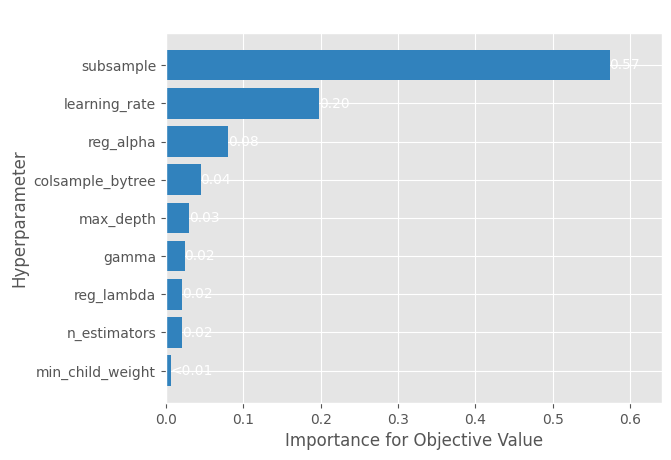

In [170]:
plot_param_importances(study);

## Use the optimal hyperparameters to train the model

In [171]:
xgb_model_4 = XGBRegressor(**study.best_params)

In [172]:
xgb_model_4.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6388687699315663, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.6111182426613264, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.032877844798754524, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=442, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [173]:
y_pred4 = xgb_model_4.predict(X_test)

In [174]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred4))
print("MAE :", mean_absolute_error(y_test,y_pred4))
print("R^2 : ", r2_score(y_test, y_pred4))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred4)))

MAPE : 0.06904232532519261
MAE : 1486.4276104371306
R^2 :  0.9510177642453841
RMSE: 2516.771350596266


## xgb model 5

In [91]:
parameters = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mape',
    'max_depth': 10,
    'learning_rate': 0.01,
    'n_estimators': 3000,
    'early_stopping_rounds': 30,
    'verbosity':0,
    'min_child_weight':10,
    'gamma': 0.18,
    'subsample':0.8,
    'colsample_bytree': 0.5,
    'reg_alpha':0.8,
    'reg_lambda':0.47,
    'random_state':42
}

In [96]:
xgb_model_5 = XGBRegressor(**parameters)

In [93]:
xgb_model_5.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

[0]	validation_0-mape:0.98968
[1]	validation_0-mape:0.97942
[2]	validation_0-mape:0.96947
[3]	validation_0-mape:0.95944
[4]	validation_0-mape:0.94885
[5]	validation_0-mape:0.93897
[6]	validation_0-mape:0.92919
[7]	validation_0-mape:0.91868
[8]	validation_0-mape:0.90919
[9]	validation_0-mape:0.89977
[10]	validation_0-mape:0.89044
[11]	validation_0-mape:0.88126
[12]	validation_0-mape:0.87206
[13]	validation_0-mape:0.86301
[14]	validation_0-mape:0.85399
[15]	validation_0-mape:0.84511
[16]	validation_0-mape:0.83609
[17]	validation_0-mape:0.82750
[18]	validation_0-mape:0.81902
[19]	validation_0-mape:0.81061
[20]	validation_0-mape:0.80232
[21]	validation_0-mape:0.79419
[22]	validation_0-mape:0.78522
[23]	validation_0-mape:0.77722
[24]	validation_0-mape:0.76922
[25]	validation_0-mape:0.76138
[26]	validation_0-mape:0.75307
[27]	validation_0-mape:0.74541
[28]	validation_0-mape:0.73778
[29]	validation_0-mape:0.73031
[30]	validation_0-mape:0.72275
[31]	validation_0-mape:0.71518
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=30,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=0.18, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [94]:
y_pred5 = xgb_model_5.predict(X_test)

In [95]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred5))
print("MAE :", mean_absolute_error(y_test,y_pred5))
print("R^2 : ", r2_score(y_test, y_pred5))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred5)))

MAPE : 0.06930807552542517
MAE : 1509.3340570399425
R^2 :  0.9488833273047319
RMSE: 2571.021733380101


## xgb model 6

In [102]:
xgb_model_6 = XGBRegressor()

In [103]:
parameters = {
    'objective': 'reg:squarederror',
    'eval_metric': 'logloss',
    'max_depth': 10,
    'learning_rate': 0.01,
    'n_estimators': 3000,
    'early_stopping_rounds': 30,
    'verbosity':0,
    'min_child_weight':10,
    'gamma': 0.18,
    'subsample':0.8,
    'colsample_bytree': 0.5,
    'reg_alpha':0.8,
    'reg_lambda':0.47,
    'random_state':42
}

In [104]:
xgb_model_6 = XGBRegressor(**parameters)

In [105]:
xgb_model_6.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

[0]	validation_0-logloss:-974078.82401
[1]	validation_0-logloss:-989856.45449
[2]	validation_0-logloss:-999124.52946
[3]	validation_0-logloss:-1005648.72872
[4]	validation_0-logloss:-1010659.34213
[5]	validation_0-logloss:-1014770.52671
[6]	validation_0-logloss:-1018178.22784
[7]	validation_0-logloss:-1021124.79442
[8]	validation_0-logloss:-1023728.12943
[9]	validation_0-logloss:-1026055.29370
[10]	validation_0-logloss:-1028117.32566
[11]	validation_0-logloss:-1030012.36398
[12]	validation_0-logloss:-1031735.85709
[13]	validation_0-logloss:-1033328.85022
[14]	validation_0-logloss:-1034806.51507
[15]	validation_0-logloss:-1036172.46641
[16]	validation_0-logloss:-1037435.46010
[17]	validation_0-logloss:-1038640.03157
[18]	validation_0-logloss:-1039783.51432
[19]	validation_0-logloss:-1040855.74401
[20]	validation_0-logloss:-1041867.67249
[21]	validation_0-logloss:-1042828.52771
[22]	validation_0-logloss:-1043730.91763
[23]	validation_0-logloss:-1044607.23083
[24]	validation_0-logloss:-10

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=30,
             enable_categorical=False, eval_metric='logloss',
             feature_types=None, gamma=0.18, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=42, ...)

In [106]:
y_pred6 = xgb_model_6.predict(X_test)

In [107]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred6))
print("MAE :", mean_absolute_error(y_test,y_pred6))
print("R^2 : ", r2_score(y_test, y_pred6))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred6)))

MAPE : 0.07160324988547503
MAE : 1560.2753878519609
R^2 :  0.9449132559197255
RMSE: 2668.996544032309


## xgb model 7

In [231]:
xgb_model_7 = XGBRegressor()

In [232]:
parameters = {
    'silent':1,
    'objective': 'reg:squarederror',
    'eval_metric': 'mape',
    'max_depth': 9,
    'learning_rate': 0.01,
    'n_estimators': 5000,
    'early_stopping_rounds': 30,
    'verbosity':0,
    'min_child_weight':1,
    'gamma': 0.9481,
    'subsample':0.5373,
    'colsample_bytree': 0.6,
    'reg_alpha':0.9,
    'reg_lambda':0.12,
    'random_state':42
}

In [233]:
xgb_model_7 = XGBRegressor(**parameters)

In [234]:
xgb_model_7.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

[0]	validation_0-mape:0.98971
[1]	validation_0-mape:0.97959
[2]	validation_0-mape:0.96964
[3]	validation_0-mape:0.95966
[4]	validation_0-mape:0.94978
[5]	validation_0-mape:0.93988
[6]	validation_0-mape:0.93002
[7]	validation_0-mape:0.91941
[8]	validation_0-mape:0.90993
[9]	validation_0-mape:0.90048
[10]	validation_0-mape:0.89113
[11]	validation_0-mape:0.88193
[12]	validation_0-mape:0.87289
[13]	validation_0-mape:0.86381
[14]	validation_0-mape:0.85483
[15]	validation_0-mape:0.84592
[16]	validation_0-mape:0.83692
[17]	validation_0-mape:0.82835
[18]	validation_0-mape:0.81987
[19]	validation_0-mape:0.81141
[20]	validation_0-mape:0.80310
[21]	validation_0-mape:0.79496
[22]	validation_0-mape:0.78620
[23]	validation_0-mape:0.77814
[24]	validation_0-mape:0.77015
[25]	validation_0-mape:0.76232
[26]	validation_0-mape:0.75418
[27]	validation_0-mape:0.74655
[28]	validation_0-mape:0.73892
[29]	validation_0-mape:0.73149
[30]	validation_0-mape:0.72392
[31]	validation_0-mape:0.71647
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=30,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=0.9481, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [126]:
y_pred7 = xgb_model_7.predict(X_test)

In [127]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred7))
print("MAE :", mean_absolute_error(y_test,y_pred7))
print("R^2 : ", r2_score(y_test, y_pred7))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred7)))

MAPE : 0.06931300810925882
MAE : 1490.535134857984
R^2 :  0.948954759303425
RMSE: 2569.2246932272983


## xgb model 8

In [184]:
xgb_model_8 = XGBRegressor()

In [241]:
parameters = {
    'verbose':False,
    'eval_metric': 'mape',
    'max_depth': 7,
    'learning_rate': 0.01,
    'n_estimators': 5000,
    'early_stopping_rounds': 30,
    'min_child_weight':1,
    'gamma': 0.29,
    'subsample':0.64,
    'colsample_bytree': 0.6,
    'reg_alpha':0.57,
    'reg_lambda':0.92,
    'random_state':42
}

In [242]:
xgb_model_8 = XGBRegressor(**parameters)

In [243]:
xgb_model_8.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

[21:27:34] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mape:0.98967
[1]	validation_0-mape:0.97952
[2]	validation_0-mape:0.96947
[3]	validation_0-mape:0.95945
[4]	validation_0-mape:0.94958
[5]	validation_0-mape:0.93966
[6]	validation_0-mape:0.92978
[7]	validation_0-mape:0.91918
[8]	validation_0-mape:0.90964
[9]	validation_0-mape:0.90022
[10]	validation_0-mape:0.89082
[11]	validation_0-mape:0.88154
[12]	validation_0-mape:0.87243
[13]	validation_0-mape:0.86337
[14]	validation_0-mape:0.85435
[15]	validation_0-mape:0.84542
[16]	validation_0-mape:0.83642
[17]	validation_0-mape:0.82780
[18]	validation_0-mape:0.81929
[19]	validation_0-mape:0.81085
[20]	validation_0-mape:0.80249
[21]	validation_0-mape:0.79431
[22]	validation_0-mape:0.78565
[23]	validation_0-mape:0.77761
[24]	validation_0-mape:0.76955
[25]	validation_0-mape:0.76171
[26]	validation_0-mape:0.75357
[27]	validation_0-mape:0.74590
[28]	validation_0-mape:0.73827
[29]	validation_0-mape:0.7

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=30,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=0.29, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [229]:
y_pred8 = xgb_model_8.predict(X_test)

In [230]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred8))
print("MAE :", mean_absolute_error(y_test,y_pred8))
print("R^2 : ", r2_score(y_test, y_pred8))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred8)))

MAPE : 0.06922967159668524
MAE : 1495.860444600791
R^2 :  0.9486400536921809
RMSE: 2577.1324532870935


# CatBoost

## cbt default params 

In [199]:
parameters = {
    'eval_metric': 'MAPE',
    'random_seed':42,
    'verbose':100
}

In [200]:
model_cbt_1 = CatBoostRegressor(**parameters)

In [201]:
model_cbt_1.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
)

Learning rate set to 0.071417
0:	learn: 0.4582005	test: 0.4346392	best: 0.4346392 (0)	total: 4.29ms	remaining: 4.29s
100:	learn: 0.0891548	test: 0.0919566	best: 0.0919566 (100)	total: 236ms	remaining: 2.1s
200:	learn: 0.0761355	test: 0.0814863	best: 0.0814863 (200)	total: 478ms	remaining: 1.9s
300:	learn: 0.0698218	test: 0.0773384	best: 0.0773384 (300)	total: 711ms	remaining: 1.65s
400:	learn: 0.0661798	test: 0.0748715	best: 0.0748715 (400)	total: 904ms	remaining: 1.35s
500:	learn: 0.0636385	test: 0.0735256	best: 0.0735256 (500)	total: 1.11s	remaining: 1.1s
600:	learn: 0.0616335	test: 0.0725534	best: 0.0725534 (600)	total: 1.3s	remaining: 867ms
700:	learn: 0.0604273	test: 0.0720716	best: 0.0720716 (700)	total: 1.5s	remaining: 640ms
800:	learn: 0.0589640	test: 0.0714491	best: 0.0714491 (800)	total: 1.7s	remaining: 422ms
900:	learn: 0.0576734	test: 0.0708522	best: 0.0708509 (899)	total: 1.9s	remaining: 209ms
999:	learn: 0.0565326	test: 0.0705305	best: 0.0705305 (999)	total: 2.12s	remaini

In [212]:
y_pred_cbt_1 = model_cbt_1.predict(X_test)

In [213]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred_cbt_1))
print("MAE :", mean_absolute_error(y_test,y_pred_cbt_1))
print("R^2 : ", r2_score(y_test, y_pred_cbt_1))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred_cbt_1)))

MAPE : 0.07053052880606142
MAE : 1517.6795025968347
R^2 :  0.9501121005410178
RMSE: 2539.9318764643426


## model_cbt_2

In [209]:
parameters = {
    'iterations':15000,
    'verbose':200,
    'od_type' : "Iter",
    'od_wait' : 500,
    'eval_metric': 'MAPE',
    'random_seed':42
}

In [210]:
model_cbt_2 = CatBoostRegressor(**parameters)

In [211]:
model_cbt_2.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
)

Learning rate set to 0.013689
0:	learn: 0.4795051	test: 0.4548565	best: 0.4548565 (0)	total: 3.6ms	remaining: 53.9s
200:	learn: 0.1345092	test: 0.1326621	best: 0.1326621 (200)	total: 495ms	remaining: 36.4s
400:	learn: 0.0971293	test: 0.0995247	best: 0.0995247 (400)	total: 881ms	remaining: 32.1s
600:	learn: 0.0859170	test: 0.0897756	best: 0.0897756 (600)	total: 1.28s	remaining: 30.6s
800:	learn: 0.0801438	test: 0.0850595	best: 0.0850595 (800)	total: 1.68s	remaining: 29.8s
1000:	learn: 0.0763859	test: 0.0822070	best: 0.0822070 (1000)	total: 2.08s	remaining: 29.1s
1200:	learn: 0.0733746	test: 0.0799329	best: 0.0799329 (1200)	total: 2.5s	remaining: 28.7s
1400:	learn: 0.0711323	test: 0.0783141	best: 0.0783141 (1400)	total: 2.92s	remaining: 28.4s
1600:	learn: 0.0692432	test: 0.0769628	best: 0.0769628 (1600)	total: 3.42s	remaining: 28.7s
1800:	learn: 0.0677686	test: 0.0759532	best: 0.0759532 (1800)	total: 3.82s	remaining: 28s
2000:	learn: 0.0666620	test: 0.0752539	best: 0.0752539 (2000)	total

In [214]:
y_pred_cbt_2 = model_cbt_2.predict(X_test)

In [215]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred_cbt_2))
print("MAE :", mean_absolute_error(y_test,y_pred_cbt_2))
print("R^2 : ", r2_score(y_test, y_pred_cbt_2))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred_cbt_2)))

MAPE : 0.0685213617510581
MAE : 1483.8261345759083
R^2 :  0.9495945086894222
RMSE: 2553.0738981933446


## model_cbt_3_loss_funcMAE 

In [216]:
parameters = {
    'iterations':10000,
    'verbose':500,
    'od_type' : "Iter",
    'od_wait' : 500,
    'eval_metric': 'MAPE',
    'loss_function': 'MAE',
    'random_seed':42
}

In [217]:
model_cbt_3_loss_funcMAE = CatBoostRegressor(**parameters)

In [218]:
model_cbt_3_loss_funcMAE.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
)

0:	learn: 0.4124760	test: 0.3958300	best: 0.3958300 (0)	total: 6.84ms	remaining: 1m 8s
500:	learn: 0.0693833	test: 0.0767474	best: 0.0767474 (500)	total: 1.32s	remaining: 25.1s
1000:	learn: 0.0600680	test: 0.0709185	best: 0.0709185 (1000)	total: 2.55s	remaining: 23s
1500:	learn: 0.0560336	test: 0.0692118	best: 0.0692113 (1499)	total: 3.86s	remaining: 21.9s
2000:	learn: 0.0536847	test: 0.0684875	best: 0.0684857 (1987)	total: 5.12s	remaining: 20.5s
2500:	learn: 0.0521229	test: 0.0681033	best: 0.0681033 (2500)	total: 6.44s	remaining: 19.3s
3000:	learn: 0.0509709	test: 0.0678706	best: 0.0678705 (2996)	total: 7.73s	remaining: 18s
3500:	learn: 0.0499984	test: 0.0677769	best: 0.0677721 (3411)	total: 9.02s	remaining: 16.7s
4000:	learn: 0.0490984	test: 0.0676675	best: 0.0676675 (4000)	total: 10.3s	remaining: 15.5s
4500:	learn: 0.0485094	test: 0.0676221	best: 0.0676096 (4472)	total: 11.6s	remaining: 14.2s
5000:	learn: 0.0479537	test: 0.0675044	best: 0.0675008 (4993)	total: 12.9s	remaining: 12.9s

In [219]:
y_pred_cbt_3 = model_cbt_3_loss_funcMAE.predict(X_test)

In [220]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred_cbt_3))
print("MAE :", mean_absolute_error(y_test,y_pred_cbt_3))
print("R^2 : ", r2_score(y_test, y_pred_cbt_3))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred_cbt_3)))

MAPE : 0.06722759466581049
MAE : 1479.3452148551714
R^2 :  0.945959379461103
RMSE: 2643.532311457623


## model_ cbt_4

In [221]:
parameters = {
    'iterations':30000,
    'learning_rate': 0.01,
    'verbose':300,
    'od_type' : "Iter",
    'od_wait' : 500,
    'eval_metric': 'MAPE',
    'loss_function': 'MAE',
    'random_seed':42
}

In [222]:
model_cbt_4 = CatBoostRegressor(**parameters)

In [223]:
model_cbt_4.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
)

0:	learn: 0.4188856	test: 0.4019143	best: 0.4019143 (0)	total: 5.08ms	remaining: 2m 32s
300:	learn: 0.1142091	test: 0.1138834	best: 0.1138834 (300)	total: 762ms	remaining: 1m 15s
600:	learn: 0.0850885	test: 0.0895934	best: 0.0895934 (600)	total: 1.5s	remaining: 1m 13s
900:	learn: 0.0776049	test: 0.0836341	best: 0.0836341 (900)	total: 2.31s	remaining: 1m 14s
1200:	learn: 0.0725335	test: 0.0794316	best: 0.0794316 (1200)	total: 3.09s	remaining: 1m 14s
1500:	learn: 0.0690252	test: 0.0768877	best: 0.0768877 (1500)	total: 3.85s	remaining: 1m 13s
1800:	learn: 0.0661071	test: 0.0749342	best: 0.0749342 (1800)	total: 4.64s	remaining: 1m 12s
2100:	learn: 0.0639203	test: 0.0734477	best: 0.0734477 (2100)	total: 5.4s	remaining: 1m 11s
2400:	learn: 0.0622112	test: 0.0724260	best: 0.0724260 (2400)	total: 6.14s	remaining: 1m 10s
2700:	learn: 0.0608320	test: 0.0716583	best: 0.0716583 (2700)	total: 6.88s	remaining: 1m 9s
3000:	learn: 0.0596554	test: 0.0710926	best: 0.0710920 (2999)	total: 7.61s	remaining

In [224]:
y_pred_cbt_4 = model_cbt_4.predict(X_test)

In [225]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred_cbt_4))
print("MAE :", mean_absolute_error(y_test,y_pred_cbt_4))
print("R^2 : ", r2_score(y_test, y_pred_cbt_4))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred_cbt_4)))

MAPE : 0.06794804973367537
MAE : 1488.3959583557069
R^2 :  0.9455333414907741
RMSE: 2653.9322115909226


# Summary: 

In [3]:
result = { 'metrics':['MAPE','MAE','R^2','RMSE'],
          'xgb_model_1':
              [0.07357927339234972,
               1590.7259413392444,
               0.9407670091533626,
               2767.618917194323],
          'xgb_model_2':
              [0.07124221072034015,
               1537.37592715713,
               0.9451938676408683,
               2662.1899342660677],
           'xgb_model_3':
              [0.06932622451623494,
               1512.159816581008,
               0.9469964609967729,
               2618.0437120858437],          
           'xgb_model_4':
              [0.06904232532519261,
                1486.4276104371306,
                0.9510177642453841,
                2516.771350596266],
           'xgb_model_5':
              [0.06930807552542517,
                1509.3340570399425,
                0.9488833273047319,
                2571.021733380101],
           'xgb_model_6':
              [0.07160324988547503,
                1560.2753878519609,
                0.9449132559197255,
                2668.996544032309],
           'xgb_model_7':
              [0.06931300810925882,
                1490.535134857984,
                0.948954759303425,
                2569.2246932272983],
           'xgb_model_8':
              [0.06922967159668524,
                1495.860444600791,
                0.9486400536921809,
                2577.1324532870935],
           'model_cbt_1':
              [0.07053052880606142,
                1517.6795025968347,
                0.9501121005410178,
                2539.9318764643426],
           'model_cbt_2':
              [0.0685213617510581,
                1483.8261345759083,
                0.9495945086894222,
                2553.0738981933446],
           'model_cbt_3':
              [0.06722759466581049,
                1479.3452148551714,
                0.945959379461103,
                2643.532311457623],
           'model_cbt_4':
              [0.06794804973367537,
                1488.3959583557069,
                0.9455333414907741,
                2653.9322115909226]
}

In [7]:
result_df = pd.DataFrame.from_dict(result)
result_df.T

,0,1,2,3
metrics,MAPE,MAE,R^2,RMSE
xgb_model_1,0.073579,1590.725941,0.940767,2767.618917
xgb_model_2,0.071242,1537.375927,0.945194,2662.189934
xgb_model_3,0.069326,1512.159817,0.946996,2618.043712
xgb_model_4,0.069042,1486.42761,0.951018,2516.771351
xgb_model_5,0.069308,1509.334057,0.948883,2571.021733
xgb_model_6,0.071603,1560.275388,0.944913,2668.996544
xgb_model_7,0.069313,1490.535135,0.948955,2569.224693
xgb_model_8,0.06923,1495.860445,0.94864,2577.132453
model_cbt_1,0.070531,1517.679503,0.950112,2539.931876
